# Extract the PSF  some stars in HD163466 Y3 field
=====================================================================

- Creation : Friday 2016 July 8th
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

Photometry of HD163466 with Y3


## 1) Import package

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc_file("../templates/matplotlibrc")

import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [109]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture,CircularAnnulus
from photutils import aperture_photometry
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

from astropy.table import hstack

In [58]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [59]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [60]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-08 21:48:52.766231
fits date format for the analysis :  2016-07-08T21:48:52


## 3) Configuration of the input file



In [61]:

object_name='HD163466_y3'

In [62]:
path='./HD163466_y3'
basefilename='AssScImHD163466_y3_5.fits' # check master bias
filename=os.path.join(path,basefilename)

## Read the header

In [63]:
hdulist = fits.open(filename)
prim_hdr = hdulist[0].header
exposure = prim_hdr['EXPOSURE']
date_obs = prim_hdr['DATE-OBS']

In [64]:
print date_obs
print 'exposure = ',exposure,'seconds'

2016-05-10T08:38:53.776
exposure =  3.0 seconds


## 4) Read the images

In [65]:
allimages = []
ccd_chan = ccdproc.CCDData.read(filename, hdu=0,unit='adu') 
allimages.append(ccd_chan)

data=ccd_chan.data/exposure

## 5) Shows the images

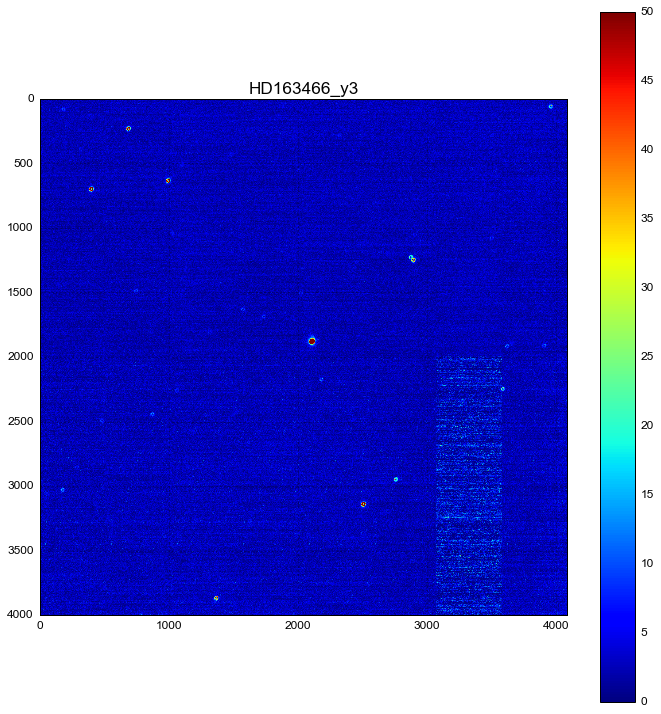

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
img=ax.imshow(ccd_chan,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)
#plt.savefig(outputfigfilename3)

# 6) Subtract background

code implemented from photutil information there:
https://photutils.readthedocs.io/en/latest/photutils/background.html#

In [67]:
from photutils.background import Background2D
bkg = Background2D(data, (100, 100), filter_size=(3, 3),method='median')

### does the background varies over the field of view ?

In [68]:
print('median background = ',bkg.background_median)
print('median rms = ',bkg.background_rms_median)

('median background = ', 0.78311265188274315)
('median rms = ', 0.73643287551029202)


### Radiography of the residual background

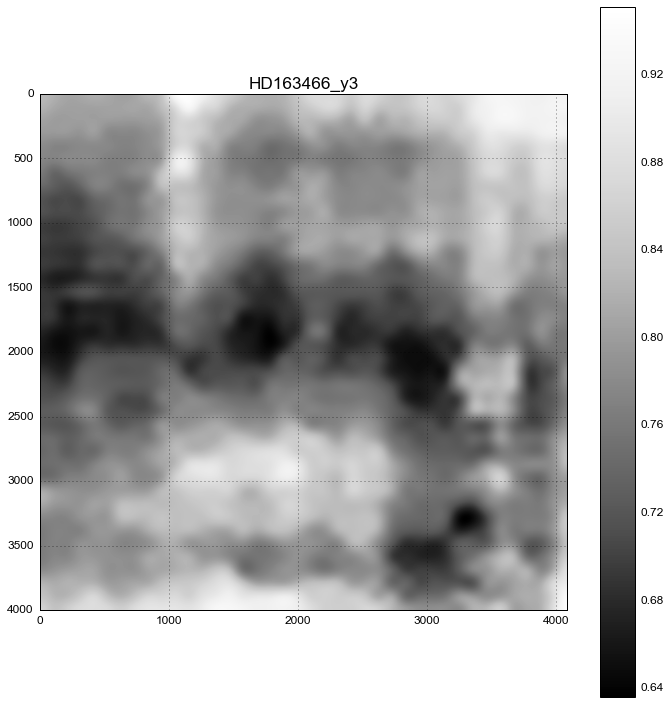

In [69]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=ax.imshow(bkg.background, cmap='Greys_r')
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

### Now subtract residual the background

In [70]:
data2=data - bkg.background

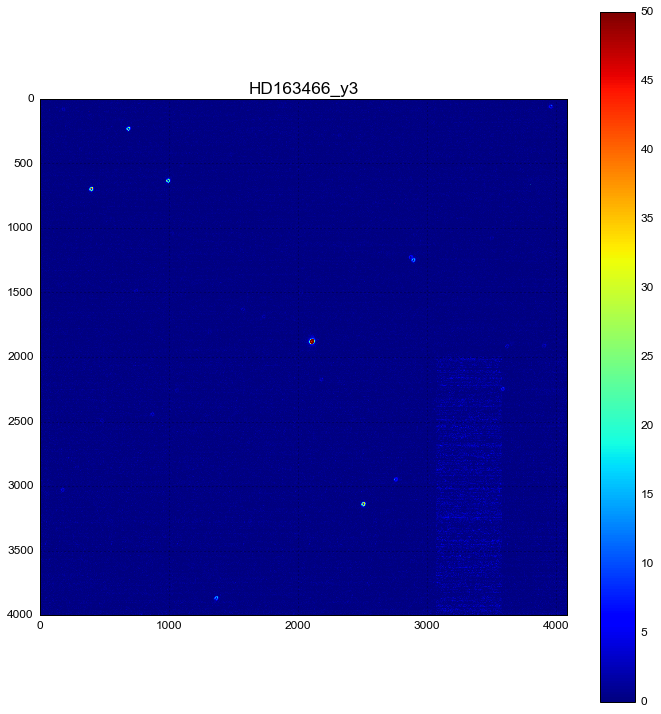

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(data2, vmin=0,vmax=50.)
#img=plt.imshow(data2)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

## Crop the star

In [72]:
wpix=200

In [73]:
(y0,x0)=np.where(data2==data2.max())

In [74]:
the_star2D=data2[y0-wpix:y0+wpix,x0-wpix:x0+wpix]

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  if __name__ == '__main__':


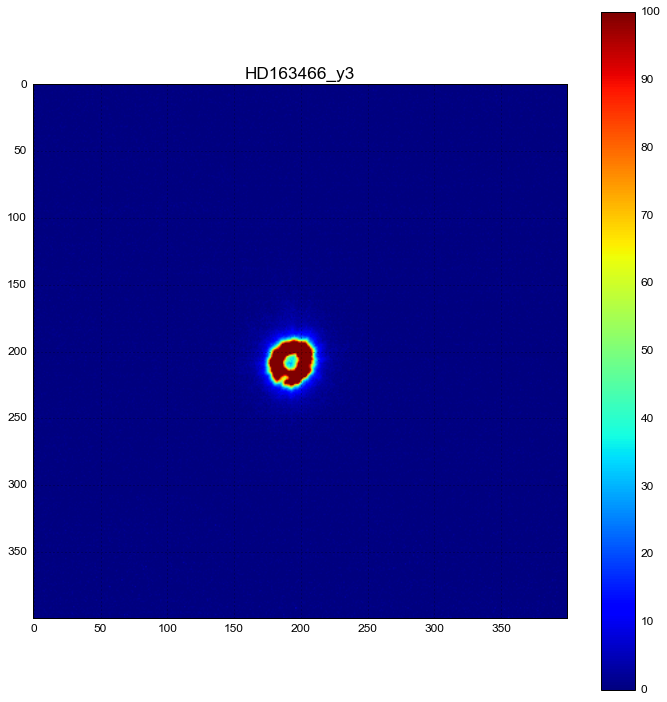

In [75]:
fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(bkg.background, origin='lower', cmap='Greys_r')
img=plt.imshow(the_star2D, vmin=0,vmax=100.)
#img=plt.imshow(data2)
plt.title(object_name)
plt.tight_layout()
plt.colorbar(img)

## 8.) Compute signal and noise

In [76]:
mean, median, std = sigma_clipped_stats(the_star2D, sigma=10.0, iters=5)    
print(mean, median, std)    

(0.10115982494184525, 0.04959488867123607, 0.86667757811632218)


In [77]:
sources = daofind(the_star2D - median, fwhm=3.0, threshold=50.*std)
sources.sort('flux')
print(sources)   

 id   xcentroid     ycentroid   ...      peak          flux           mag      
--- ------------- ------------- ... ------------- ------------- ---------------
  6 198.869063506 218.374356845 ... 195.895826128 1.25434652654 -0.246043828824
  4 200.359466976 211.112027874 ... 185.785206455 1.29462981969 -0.280364015156
  2 183.568718941 204.429668063 ...  258.09871755  1.3946982958 -0.361200675585
  3 181.061820839 208.182321757 ... 305.460726481 1.84510798639 -0.665054471659
  5 185.218089407 215.031376169 ... 264.242250274 2.31718069835 -0.912399755639
  1 199.906644824 200.128247521 ...  372.57125864  2.9383329207  -1.17025250232


In [78]:
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
6,198.869063506,218.374356845,0.462914486798,-0.658257834252,0.650350934075,25.0,0.0,195.895826128,1.25434652654,-0.246043828824
4,200.359466976,211.112027874,0.435696738306,-0.114667476745,0.38033396033,25.0,0.0,185.785206455,1.29462981969,-0.280364015156
2,183.568718941,204.429668063,0.438129857586,-0.796983173964,-0.406906304936,25.0,0.0,258.09871755,1.3946982958,-0.361200675585
3,181.061820839,208.182321757,0.458707183167,-0.2083039254,-0.713854791213,25.0,0.0,305.460726481,1.84510798639,-0.665054471659
5,185.218089407,215.031376169,0.514962050852,-0.774123196584,-0.34762007863,25.0,0.0,264.242250274,2.31718069835,-0.912399755639
1,199.906644824,200.128247521,0.50759724629,-0.272112445208,0.534159168095,25.0,0.0,372.57125864,2.9383329207,-1.17025250232


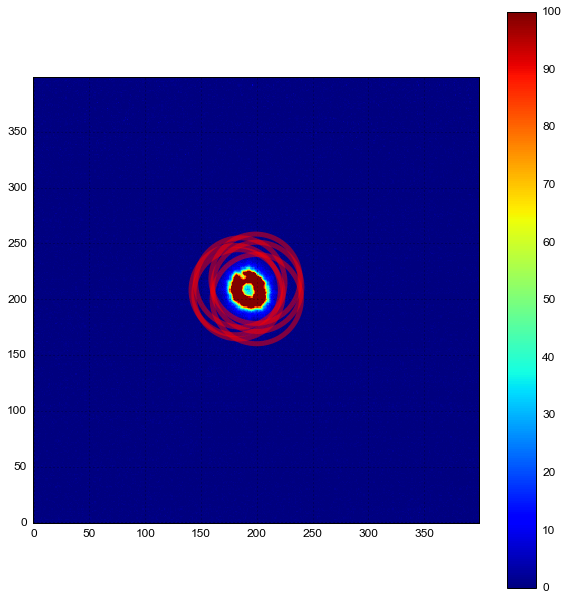

In [79]:
fig, ax = plt.subplots(figsize=(10, 10))
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=40.)
norm = ImageNormalize(stretch=SqrtStretch())
im=ax.imshow(the_star2D,vmin=0,vmax=100.,origin='lower',interpolation='None')
#ax.imshow(data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='red', lw=5., alpha=0.5)
plt.colorbar(im)

## The PSF

In [80]:
thePSF_2D=the_star2D

In [81]:
thepsfX=the_star2D.sum(axis=0)
thepsfY=the_star2D.sum(axis=1)

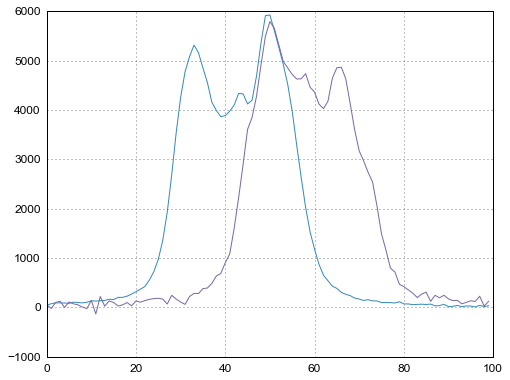

In [82]:
plt.plot(thepsfX[150:250])
plt.plot(thepsfY[150:250])

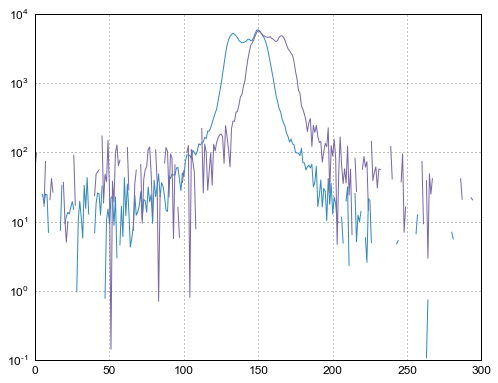

In [83]:
plt.semilogy(thepsfX[50:350])
plt.semilogy(thepsfY[50:350])

In [84]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    weights=np.where(weights>0,weights,0)
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

In [85]:
np.average(np.arange(thepsfX.shape[0]),weights=thepsfX)

191.638831177284

In [86]:
(mx,sigx)=weighted_avg_and_std(np.arange(thepsfX.shape[0]),thepsfX)

In [87]:
(my,sigy)=weighted_avg_and_std(np.arange(thepsfY.shape[0]),thepsfY)

In [88]:
print 'sigx = ',sigx

sigx =  18.582359104


In [89]:
print 'sigy = ',sigy

sigy =  31.0596897639


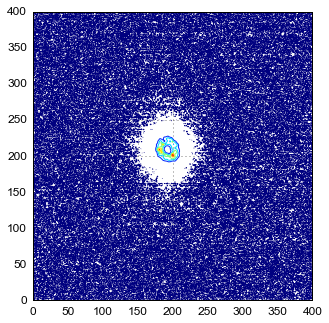

In [90]:
plt.figure(figsize=(5,5))
#onepsf2 = onepsf / np.linalg.norm(onepsf, axis=-1)[:, np.newaxis]
onepsf2 = thePSF_2D / np.sum(thePSF_2D)
levels=np.array([1,10.,100.,1000.,10000.,100000.])
#plt.contour(onepsf2,levels=levels) 
plt.contour(onepsf2,origin='lower')

# Photometry

In [91]:
apertures = CircularAperture([my,mx], r=3*max([sigx,sigy]))

In [92]:
phot_table = aperture_photometry(the_star2D, apertures)

In [93]:
print(phot_table)

 aperture_sum  xcenter [1]   ycenter [1] 
                                         
------------- ------------- -------------
154103.113905 206.887746436 192.104575773


In [94]:
sigmapix=max([sigx,sigy])
position=[my,mx]

In [95]:
#aperture_names=['ap_1sig','ap_2sig','ap_3sig','ap_4sig','ap_5sig','ap_10sig']
radii = np.array([sigmapix,2*sigmapix,3*sigmapix,4*sigmapix,5*sigmapix,10*sigmapix])
flux = []

In [96]:
for radius in radii:
    flux.append(aperture_photometry(the_star2D, CircularAperture(positions, radius)))

In [98]:
phot_table = hstack(flux)

In [99]:
print(phot_table['aperture_sum_1', 'aperture_sum_2', 'aperture_sum_3','aperture_sum_4', 'aperture_sum_5', 'aperture_sum_6'])   

aperture_sum_1 aperture_sum_2 aperture_sum_3 ... aperture_sum_5 aperture_sum_6
                                             ...                              
-------------- -------------- -------------- ... -------------- --------------
 141828.006276  152279.695783  154305.417248 ...   154348.01378  154597.343499
  143688.47499  152343.055059  154347.681339 ...    154581.9972  154597.343499
 142834.013344  152363.641267  154448.413885 ...  154915.949913  154597.343499
 141428.786959  152299.422348   154545.40208 ...  154865.166226  154597.343499
 142131.303383  152363.485754  154435.130292 ...  154552.902241  154597.343499
 142182.222303  152202.921755  154266.796637 ...  154727.200784  154597.343499


## Final choice

In [100]:
star_aperture=CircularAperture(position, 3*sigmapix)

In [101]:
rawflux_table = aperture_photometry(the_star2D, star_aperture)

In [102]:
annulus_apertures = CircularAnnulus(position, r_in=5*sigmapix, r_out=7*sigmapix)

In [103]:
bkgflux_table = aperture_photometry(the_star2D, annulus_apertures)

In [104]:
phot_table = hstack([rawflux_table, bkgflux_table], table_names=['raw', 'bkg'])

In [105]:
bkg_mean = phot_table['aperture_sum_bkg'] / annulus_apertures.area()

## Result on photometry

In [106]:
bkg_sum = bkg_mean * apertures.area()
final_sum = phot_table['aperture_sum_raw'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
print(phot_table['residual_aperture_sum']) 

residual_aperture_sum
                     
---------------------
        154250.623534


### Background fluctuation

In [107]:
med=np.median(the_star2D)   # average background level

In [108]:
data_error_scale=np.sqrt(np.median((the_star2D-med)**2))  # RMS